# Проект: классификация

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [35]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [36]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [37]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()


management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [38]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
print(df.balance[0])
print(df.balance[0].replace(' ', '').strip('$ ').replace(",", "."))
float(df.balance[0].replace(' ', '').strip('$ ').replace(",", "."))

 2 343,00 $ 
2343.00


2343.0

In [39]:
type(df.balance[0])
df.balance[0]
df.balance[0].strip().strip('$').strip()

'2 343,00'

In [40]:
type(df.balance[0])

str

In [41]:
for i in range(0,len(df['balance'])):
    if type(df.balance[i]) is str:
        df.balance[i] = float(df.balance[i].replace(' ', '').strip('$').replace(",", "."))

In [42]:
df.balance.mean()

1529.1290293615875

### Задание 4

In [43]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
med = df.balance.median()
df.balance = df.balance.fillna(med)

In [44]:
df.balance.info()

<class 'pandas.core.series.Series'>
RangeIndex: 11162 entries, 0 to 11161
Series name: balance
Non-Null Count  Dtype  
--------------  -----  
11162 non-null  float64
dtypes: float64(1)
memory usage: 87.3 KB


In [45]:
df.balance.describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 5

In [46]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_mode = df.job.mode()
df.job[df.job=='unknown'] = 'management'

edu_mode = df.education.mode()
df.education[df.education=='unknown'] = 'secondary'

In [47]:
# df.education.mode()

In [48]:
# df.job.mode()

In [49]:
round(df[(df['job']=='management') & (df['education']=='secondary')]['balance'].mean(),3)

1598.883

### Задание 6

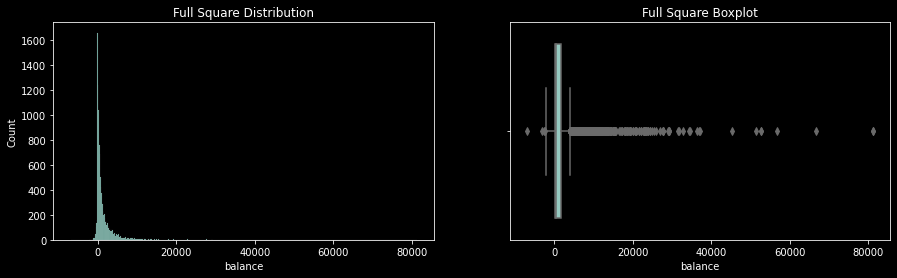

In [50]:
# удалите все выбросы для признака balance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

In [51]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print(lower_bound,upper_bound)
    return outliers, cleaned

In [52]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [53]:
df = cleaned

## Часть 2:  Разведывательный анализ

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


### Задание 1

In [55]:
df[df.deposit=='yes'].count()[0]

4681

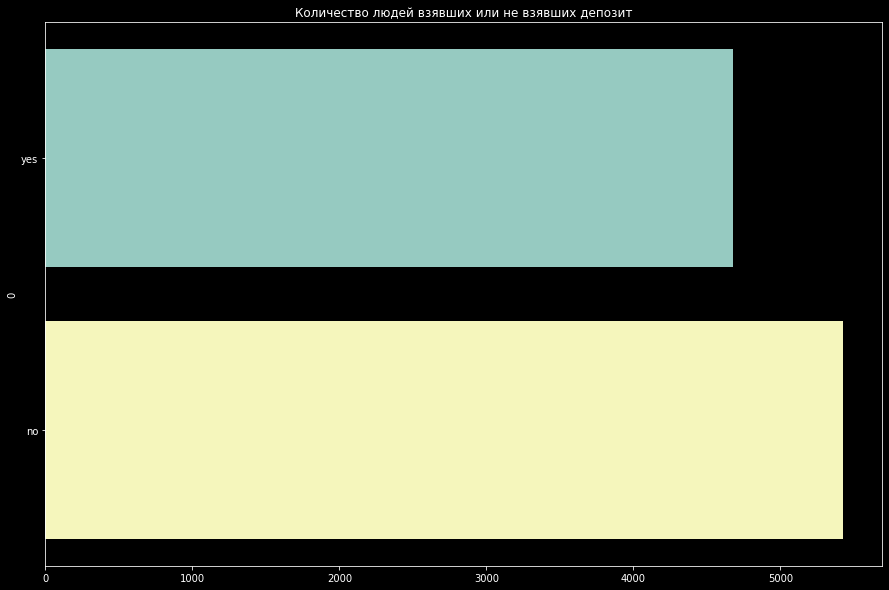

In [56]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

bpdf = pd.DataFrame(
    ['yes','no'],
    [df[df.deposit=='yes'].count()[0],df[df.deposit=='no'].count()[0]]
)


fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data=df,
    x=bpdf.index,
    y=bpdf[0]
)

barplot.set_title('Количество людей взявших или не взявших депозит');

In [57]:
df[(df.deposit=='yes')].count()[0]

4681

### Задания 2 и 3

<Axes: >

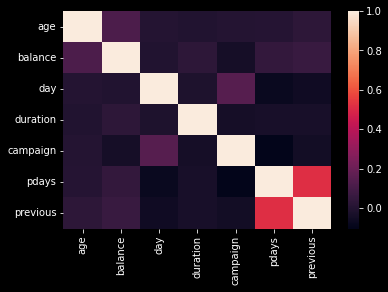

In [58]:
corr = df.select_dtypes('number').corr()

# plot the heatmap

sns.heatmap(corr)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        10105 non-null  object
 1   job        10105 non-null  object
 2   marital    10105 non-null  object
 3   education  10105 non-null  object
 4   default    10105 non-null  object
 5   balance    10105 non-null  object
 6   housing    10105 non-null  object
 7   loan       10105 non-null  object
 8   contact    10105 non-null  object
 9   day        10105 non-null  object
 10  month      10105 non-null  object
 11  duration   10105 non-null  object
 12  campaign   10105 non-null  object
 13  pdays      10105 non-null  object
 14  previous   10105 non-null  object
 15  poutcome   10105 non-null  object
 16  deposit    10105 non-null  object
dtypes: object(17)
memory usage: 1.4+ MB


In [ ]:
sns.heatmap(df.corr())

ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

### Задания 4 и 5

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna